# Use Toplez Matrix to turn the 2D convolution into matrix multiplication

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn

import numpy as np

import scipy.linalg as linalg
import PIL.Image as Image
import matplotlib.pyplot as plt
import time
from concurrent.futures import ThreadPoolExecutor

In [2]:
# Convolution is equivalent with Unfold + Matrix Multiplication + Fold (or view to output shape)
inp = torch.randn(1, 3, 10, 12)
w = torch.randn(2, 3, 4, 5)
inp_unf = torch.nn.functional.unfold(inp, (4, 5))
out_unf = inp_unf.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
out = out_unf.view(1, 2, 7, 8)
(torch.nn.functional.conv2d(inp, w) - out).abs().max()

tensor(3.8147e-06)

# Try to understand how it works

In [3]:
print(inp_unf.shape, w.view(w.size(0), -1).t().shape)

torch.Size([1, 60, 56]) torch.Size([60, 2])


## Generate specific matrix for convolution

In [4]:
inp = np.arange(1,121)
w = np.arange(1,21)
inp = torch.from_numpy(inp).float().view(1, 1, 10, 12)
print("original input:\n", inp.data)
w = torch.from_numpy(w).float().view(1, 1, 4, 5)
#print(inp)
unfolded = torch.nn.functional.unfold(inp, (4, 5), padding=0, stride=1)
print("\nshape after unfold: ", unfolded.shape)
print(f"{unfolded.shape[1]} is the block size, {unfolded.shape[2]} is the number of blocks\n")
print("Let's slice and see one block, then it makes total sense, unfolded[0,:,0] is:\n", unfolded[0, :,0])
print("\nreshape the slice into block shape: \n", unfolded[0, :,0].reshape(4,5))

original input:
 tensor([[[[  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
            12.],
          [ 13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
            24.],
          [ 25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
            36.],
          [ 37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,
            48.],
          [ 49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.,
            60.],
          [ 61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,  70.,  71.,
            72.],
          [ 73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,  82.,  83.,
            84.],
          [ 85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,
            96.],
          [ 97.,  98.,  99., 100., 101., 102., 103., 104., 105., 106., 107.,
           108.],
          [109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
           120.]]]])

shape after unfold:  torch.Si

In [5]:
print(w)

tensor([[[[ 1.,  2.,  3.,  4.,  5.],
          [ 6.,  7.,  8.,  9., 10.],
          [11., 12., 13., 14., 15.],
          [16., 17., 18., 19., 20.]]]])


# Explanation

The unfold function returns a tensor with size: $(N,C\times\Pi(\text{kernel size}),L)$ where $C\times\Pi(\text{kernel size})$ is the block size, and $L$ is the total number of such blocks.

Therefore we flatten the kernel into a 1D tensor, and then use the transposed version (expose each block) of unfolded tensor, then multiply it with the flattened kernel tensor.

In [6]:
out_unf = unfolded.transpose(1, 2).matmul(w.view(w.size(0), -1).t()).transpose(1, 2)
out = out_unf.view(1, 1, 7, 8)
(torch.nn.functional.conv2d(inp, w) - out).abs().max()

tensor(0.)

# Multi-Channel Convolution as Matrix Multiplication

In [7]:
def toeplitz_1_ch(kernel, input_size):
    # shapes
    k_h, k_w = kernel.shape
    i_h, i_w = input_size
    o_h, o_w = i_h-k_h+1, i_w-k_w+1

    # construct 1d conv toeplitz matrices for each row of the kernel
    toeplitz = []
    for r in range(k_h):
        toeplitz.append(linalg.toeplitz(c=(kernel[r,0], *np.zeros(i_w-k_w)), r=(*kernel[r], *np.zeros(i_w-k_w))))

    # construct toeplitz matrix of toeplitz matrices (just for padding=0)
    h_blocks, w_blocks = o_h, i_h
    h_block, w_block = toeplitz[0].shape

    W_conv = np.zeros((h_blocks, h_block, w_blocks, w_block))

    for i, B in enumerate(toeplitz):
        for j in range(o_h):
            W_conv[j, :, i+j, :] = B

    W_conv.shape = (h_blocks*h_block, w_blocks*w_block)

    return W_conv

def toeplitz_mult_ch(kernel, input_size):
    """Compute toeplitz matrix for 2d conv with multiple in and out channels.
    Args:
        kernel: shape=(n_out, n_in, H_k, W_k)
        input_size: (n_in, H_i, W_i)"""

    kernel_size = kernel.shape
    output_size = (kernel_size[0], input_size[1] - (kernel_size[2] - 1), input_size[2] - (kernel_size[3] - 1))
    T = np.zeros((output_size[0], int(np.prod(output_size[1:])), input_size[0], int(np.prod(input_size[1:]))))

    def process_channel(args):
        i, ks, input_size = args
        for j, k in enumerate(ks):  # loop over input channel
            T_k = toeplitz_1_ch(k, input_size[1:])
            T[i, :, j, :] = T_k

    with ThreadPoolExecutor() as executor:
        executor.map(process_channel, [(i, ks, input_size) for i, ks in enumerate(kernel)])

    T.shape = (np.prod(output_size), np.prod(input_size))
    
    return T

In [8]:
kernel = np.arange(1,5).reshape(2,2)
print("2d kernel is:\n", kernel)
test = toeplitz_1_ch(kernel=kernel, input_size=(4,4))
print("\nshape for the toeplitz matrix: ", test.shape)
print("\nthe entire toeplitz matrix:\n", test)
inp = np.arange(1,17)#.reshape(1,1,10,12)
print("\ninput is:\n", inp.reshape(4,4))
print("\nkernel is:\n", kernel)

print("\nflattened input is:\n", inp)
output = test @ inp
print(f"\n output {output.shape} is:\n", output)

2d kernel is:
 [[1 2]
 [3 4]]

shape for the toeplitz matrix:  (9, 16)

the entire toeplitz matrix:
 [[1. 2. 0. 0. 3. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 2. 0. 0. 3. 4. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 2. 0. 0. 3. 4. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 2. 0. 0. 3. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 2. 0. 0. 3. 4. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 3. 4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 3. 4. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 3. 4. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 3. 4.]]

input is:
 [[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]

kernel is:
 [[1 2]
 [3 4]]

flattened input is:
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]

 output (9,) is:
 [ 44.  54.  64.  84.  94. 104. 124. 134. 144.]


In [9]:
k = np.random.randn(128*3*2*2).reshape((128,3,2,2))
i = np.random.randn(3,4,4)

T = toeplitz_mult_ch(k, i.shape)[None, ...]
i = i.flatten()[None, :, None]
out = T.dot(i.flatten()).reshape((1,128,3,3))

print("Toeplitz matrix shape: ", T.shape)
print("Input shape: ", i.shape)
print("Output shape: ", out.shape)

# check correctness of convolution via toeplitz matrix
print(np.sum((out - F.conv2d(torch.tensor(i).view(1,3,4,4), torch.tensor(k)).numpy())**2))

Toeplitz matrix shape:  (1, 1152, 48)
Input shape:  (1, 48, 1)
Output shape:  (1, 128, 3, 3)
2.556438687203901e-28


## Test on Pytorch conv sparse coding problem using conv_transpose2d

In [10]:
x = np.random.rand(1, 16, 32, 32)
k = np.random.rand(16, 3, 9, 9)

y = F.conv_transpose2d(torch.tensor(x), torch.tensor(k), padding=4)
print(y.shape)

# input size is (3,40,40) because we manually padded the input
input_size = (3,40,40)
C = toeplitz_mult_ch(k, input_size)

test = C.T @ x.flatten()[:, None]
test = test.reshape(3, 40, 40)

print(np.sum((test[:,4:-4,4:-4] - y.numpy())**2))

torch.Size([1, 3, 32, 32])


2.643276246149157e-22


# Let's try this with shrinkage algorithm

image shape: (32, 32, 3) padded image shape: (40, 40, 3)


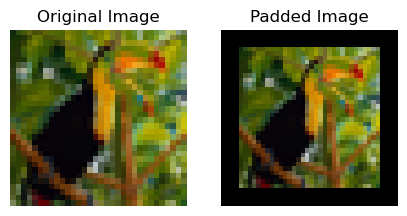

In [11]:
img = Image.open('img_002_SRF_2_LR.png')
img = img.resize((32,32),Image.BICUBIC)
img = np.asarray(img)
# normalize img
img = img/255.0
# zero pad image by adding 3 zeros to each side
img_pad = np.pad(img, ((4,4),(4,4),(0,0)), mode='constant')

fig, axs = plt.subplots(1, 2, figsize=(5, 3))
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(img_pad)
axs[1].set_title('Padded Image')
axs[1].axis('off')

print("image shape:", img.shape, "padded image shape:", img_pad.shape)

In [12]:
out_ch = 32
# initialize kernel
k = np.random.randn(out_ch*3*9*9).reshape((out_ch,3*9*9))

# Normalize kernel
k_ = k / np.linalg.norm(k, axis=1, keepdims=True)#.reshape((32,3,9,9))
k_ = k_.reshape((out_ch,3,9,9))

# Normalize the toeplitz matrix
k = k.reshape((out_ch,3,9,9))
C = toeplitz_mult_ch(k, (3,40,40))
C = C / np.linalg.norm(C, axis=1, keepdims=True)
print(f"the toeplitz matrix for {out_ch}x3x9x9 kernel shape: ", C.shape)
print("flattened padded image shape: ", img_pad.flatten().shape)

the toeplitz matrix for 32x3x9x9 kernel shape:  (32768, 4800)
flattened padded image shape:  (4800,)


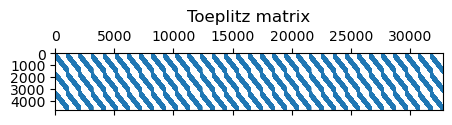

In [13]:
# visualize C
plt.figure(figsize=(5,5))
plt.spy(C.T, markersize=0.01)
plt.title('Toeplitz matrix')
plt.show()

In [14]:
# calculate sparsity level of C
sparsity = np.sum(C == 0) / C.size
print(f"sparsity level of C: {sparsity}")
print("shape of C: ", C.shape)

sparsity level of C: 0.949375
shape of C:  (32768, 4800)


In [15]:
# try everything in pytorch
C_torch = torch.FloatTensor(C).unsqueeze(0).transpose(-1,-2)
y = torch.FloatTensor(img_pad).permute(2,0,1).flatten()[None, :, None]
print("pytorch image shape:", y.shape)
print("pytorch toeplitz matrix shape:", C_torch.shape)
x = C_torch.transpose(-1,-2) @ y
print("state shape: ", x.shape)

# check correctness of convolution via toeplitz matrix
print(np.sum((x.numpy().reshape(1,out_ch,32,32) - F.conv2d(y.view(1,3,40,40), torch.FloatTensor(k_)).numpy())**2))

pytorch image shape: torch.Size([1, 4800, 1])
pytorch toeplitz matrix shape: torch.Size([1, 4800, 32768])
state shape:  torch.Size([1, 32768, 1])
2.1169419e-10


In [16]:
def conjugate_gradient(A, b, x=None, tol=1e-3, max_iterations=50):
    if x is None:
        x = torch.zeros_like(b)
    
    r = b - torch.matmul(A, x)
    p = r.clone()
    rs_old = r.transpose(-1,-2) @ r#torch.dot(r, r)
    
    for i in range(max_iterations):
        Ap = torch.matmul(A, p)
        alpha = rs_old / (p.transpose(-1,-2) @ Ap)#torch.dot(p, Ap)
        x += alpha * p
        r -= alpha * Ap
        rs_new = r.transpose(-1,-2) @ r#torch.dot(r, r)
        
        if torch.sqrt(rs_new) < tol:
            break
        
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new
    # print(i, rs_new)
    return x

In [64]:
mu = 0.1
Cy = x.clone()
x_k = x.clone()
I_x = torch.eye(C_torch.shape[-2]).unsqueeze(0)
loss_list = []
#CTC = C_torch.transpose(-1,-2) @ C_torch
for i in range(14):
    W_inv = torch.div(torch.abs(x_k), mu)
    D = I_x+(C_torch * W_inv.transpose(-1,-2)) @ C_torch.transpose(-1,-2)
    v = (C_torch * W_inv.transpose(-1,-2)) @ Cy
    # print(D.shape, v.shape)
    x_k = W_inv * Cy - (W_inv.transpose(-1,-2) * C_torch).transpose(-1,-2) @ conjugate_gradient(D, v)
                        # torch.inverse(D) @ v
    #CTC = C_torch.transpose(-1,-2) @ C_torch
    left = (CTC + torch.diag(1 / W_inv.squeeze()).unsqueeze(0)) @ x_k
    # check if the KKT condition is met
    print(torch.sum(torch.square(left-Cy)).item())
    loss = torch.norm(y - C_torch @ x_k).item()#+mu * torch.norm(x_k,1).item()
    loss_list.append(loss)

9.770428732736036e-06
5.578005584538914e-06
4.136124516662676e-06
8.182552846847102e-06
3.4778970530169317e-06
5.655732820741832e-06
7.80496520746965e-06
9.63436013989849e-06
4.548118795355549e-06
5.996472737024305e-06
6.8698918767040595e-06
8.635576705273706e-06
3.403180244276882e-06
4.253656697983388e-06


In [60]:
x_Shrinkage = x_k.clone()
print(min(loss_list))

1.03374183177948


In [41]:
Rz = torch.zeros((1, out_ch, 32, 32), requires_grad=True)
R = torch.zeros((1, out_ch, 32, 32), requires_grad=True)
old_R = R.clone().detach()
tkx = 1
tk_1x = 1
lossx_FISTA = []
img_batch = y.view(1, 3, 40, 40)[:, :, 4:-4, 4:-4]
for i in range(200):
    Lx = torch.ones((1, 1 ,1 ,1))
    pred_z = F.conv_transpose2d(Rz, torch.FloatTensor(k_), padding=4)
    const = ((img_batch-pred_z)**2).sum((-1,-2,-3))
    const.sum().backward()
    const = const.data.clone().detach()
    grad_zk = (Rz.grad.data.clone().detach())
    stop_linesearch = torch.zeros((1, 1))
    zero_tensor = torch.zeros(Rz.shape)
    keep_going = 1
    
    while keep_going:
        gk = Rz - grad_zk/Lx
        R.data = (torch.sign(gk)*(torch.max((torch.abs(gk)-mu/Lx),zero_tensor))).clone() #soft thresholding
        pred = F.conv_transpose2d(R, torch.FloatTensor(k_), padding=4)
        temp1 = ((img_batch - pred) ** 2).sum((-1,-2,-3))
        temp2 = const +((R - Rz)*grad_zk).sum((-1,-2,-3))+((Lx/2).sum((-1,-2,-3)))*(((R - Rz)**2).sum((-1,-2,-3)))
        stop_linesearch[temp1<= temp2] = True
        decay = torch.ones((1, 1))
        decay = (1-stop_linesearch)*2
        decay[decay==0] = 1
        Lx = Lx*decay.unsqueeze(-1).unsqueeze(-1)
        if (temp1.sum())<= (temp2.sum()):
            keep_going = 0

        
    tk_1x = 1+((((i+1))**8-1)/2) # the major contribution: Faster Fista step
    Rz.data = (R.clone().detach() + (tkx - 1)/(tk_1x)*(R.clone().detach() - old_R)).clone()
    old_R = R.clone().detach()
    tkx = tk_1x
    Rz.grad.zero_()
    lossx_FISTA.append(temp1.cpu().detach().numpy())

[3.7615216]


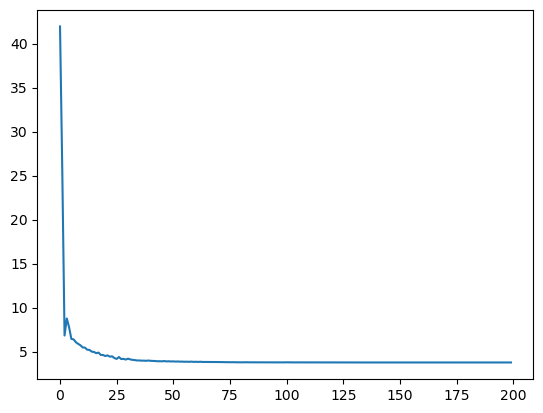

In [61]:
plt.plot(lossx_FISTA)
print(min(lossx_FISTA))

In [66]:
x_FISTA = R.clone().detach().flatten().unsqueeze(-1)
print(x_Shrinkage.shape, x_FISTA.shape)
print((torch.norm(x_Shrinkage-x_FISTA)/torch.norm(x_FISTA)).item())

torch.Size([1, 32768, 1]) torch.Size([32768, 1])
0.6635251045227051


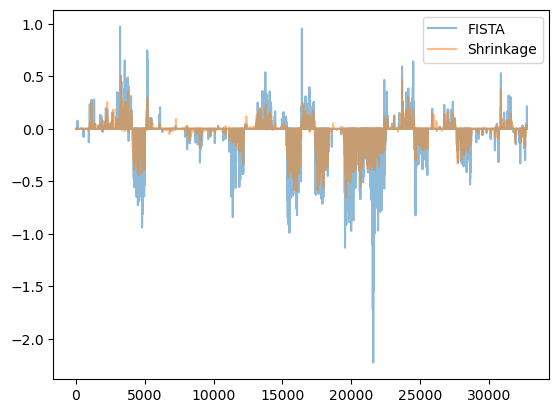

In [65]:
plt.plot(x_FISTA.squeeze().cpu().detach().numpy(), alpha=0.5)
plt.plot(x_Shrinkage.squeeze().cpu().detach().numpy(), alpha=0.5)
plt.legend(['FISTA', 'Shrinkage'])

In [68]:
print("sparsity of FISTA: ", torch.sum(x_FISTA == 0).item()/x_FISTA.size(0))
print("sparsity of Shrinkage: ", torch.sum(torch.abs(x_Shrinkage) < 1e-5).item()/x_Shrinkage.size(1))

sparsity of FISTA:  0.912261962890625
sparsity of Shrinkage:  0.55419921875


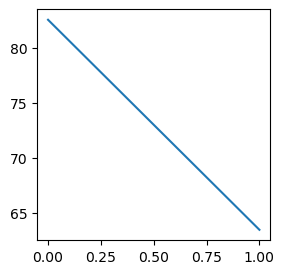

In [49]:
plt.figure(figsize=(3,3))
plt.plot(loss_list)

the ratio of zero elements is 3.66%


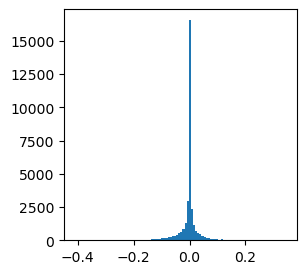

In [50]:
plt.figure(figsize=(3,3))
_ = plt.hist(x_k.numpy().flatten(), bins=100)
print(f"the ratio of zero elements is {float(torch.sum(torch.abs(x_k)<1e-5)/(np.prod(x_k.shape)))*100:.2f}%")
x_shrinkage = x_k.numpy().flatten().copy()

(-0.5, 31.5, 31.5, -0.5)

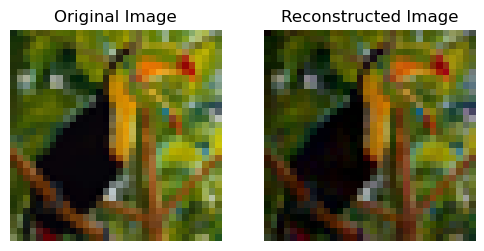

In [69]:
test_recon = (C_torch @ x_k).view(3,40,40).permute(1,2,0).numpy()

fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(img)
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(test_recon[4:-4,4:-4,:].clip(0,1))
ax[1].set_title('Reconstructed Image')
ax[1].axis('off')

# Test Matrix B

In [70]:
in_ch = 32
out_ch = 32
# initialize kernel
k = np.abs(np.random.rand(out_ch*in_ch*9*9).reshape((out_ch,in_ch*9*9)) * 0.1)

# Normalize kernel
k_ = k / np.linalg.norm(k, axis=1, keepdims=True)#.reshape((128,3,9,9))
k_ = k_.reshape((out_ch,in_ch,9,9))

# Normalize the toeplitz matrix
k = k.reshape((out_ch,in_ch,9,9))
B = toeplitz_mult_ch(k_, (in_ch,24,24))
B = B / np.linalg.norm(B, axis=1, keepdims=True)
print(f"the toeplitz matrix for {out_ch}x{in_ch}x9x9 kernel shape: ", B.shape)
# print("flattened padded image shape: ", img_pad.flatten().shape)

the toeplitz matrix for 32x32x9x9 kernel shape:  (8192, 18432)


In [92]:
pool = nn.MaxPool2d(2, stride=2, return_indices=True)
unpool = nn.MaxUnpool2d(2, stride=2)
print("inferenced state size:", x_k.shape)
# we need to pad the state
x_inp = x_k.view(1, in_ch, 32, 32)
print("reshaped state size:", x_inp.shape)

x_p, inx = pool(x_inp)
print("pooled state size:", x_p.shape)
# pad the pooled state with 4 zeros on each side
x_p = F.pad(x_p, (4,4,4,4))
print("padded pooled state size:", x_p.shape)

x_abs = torch.abs(x_p.flatten(1).unsqueeze(-1))

print("pooled state size after flattening for convolution Toeplitz matrix:", x_abs.shape)

# sparse coefficient for cause
B_torch = torch.FloatTensor(B).unsqueeze(0).transpose(-1,-2)
print("pytorch toeplitz matrix shape:", B_torch.shape)

u_k = torch.abs(torch.rand(1, B_torch.shape[-1], 1))# * 10
#u_k = torch.ones(1, B_torch.shape[-1], 1) * 100
u_k = u_k / torch.norm(u_k, dim=1, keepdim=True)

gamma0 = 0.5

print("initial guess max, min:", u_k.max(), u_k.min())

inferenced state size: torch.Size([1, 32768, 1])
reshaped state size: torch.Size([1, 32, 32, 32])
pooled state size: torch.Size([1, 32, 16, 16])
padded pooled state size: torch.Size([1, 32, 24, 24])
pooled state size after flattening for convolution Toeplitz matrix: torch.Size([1, 18432, 1])
pytorch toeplitz matrix shape: torch.Size([1, 18432, 8192])
initial guess max, min: tensor(0.0192) tensor(2.7016e-06)


In [93]:
loss_list_u = []
beta = 0.1
for i in range(50):
    # print(f"iteration {i+1}, loss: {loss:.4f}")
    W_inv = torch.div(torch.abs(u_k), beta)
    u_k = W_inv * B_torch.transpose(-1,-2) @ (gamma0 * x_abs * torch.exp(-B_torch @ u_k))
    loss = torch.abs(gamma0 * ((torch.exp(-B_torch @ u_k)) * x_abs)).sum().item()# + beta * torch.norm(u_k,1).item()
    loss_list_u.append(loss)
    
u_index = u_k / torch.norm(u_k)
u_index = torch.abs(u_index) < 1e-5
u_k[u_index] = 0

In [73]:
print(x_abs.shape)
print(torch.exp(-B_torch @ u_k).shape)

torch.Size([1, 18432, 1])
torch.Size([1, 18432, 1])


In [74]:
print("final guess max, min:", u_k.max(), u_k.min())

final guess max, min: tensor(9.3057) tensor(0.)


In [75]:
B_torch.shape

torch.Size([1, 18432, 8192])

Text(0.5, 1.0, 'U Loss')

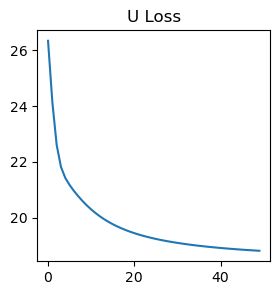

In [94]:
#plt.plot(loss_list_u)
fig, ax = plt.subplots(figsize=(3,3))
ax.plot(loss_list_u)
ax.set_title('U Loss')

In [95]:
loss_list_u[-1]

18.808462142944336

u_k shape: torch.Size([1, 8192, 1])


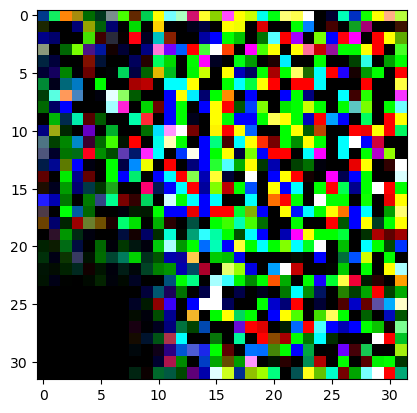

In [78]:
print("u_k shape:", u_k.shape)
# u_k_rec = u_k.view(1, out_ch, 16, 16)
recon = B_torch @ u_k
recon = recon.view(1, out_ch, 24, 24)[:,:,4:-4,4:-4]
recon = unpool(recon, inx)
recon = recon.flatten(1).unsqueeze(-1)
#print(recon.min(), recon.max())
recon = C_torch @ recon
#print(recon.min(), recon.max())
recon = recon.view(3,40,40).permute(1,2,0).numpy()[4:-4,4:-4,:]
plt.imshow(recon.clip(0,1))
#recon = recon.view(1, out_ch, 24, 24)

the ratio of zero elements is 86.01%


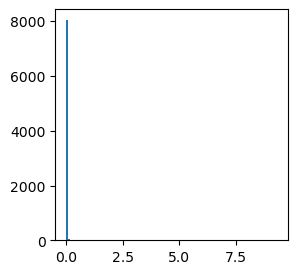

In [79]:
# histogram of u_k
plt.figure(figsize=(3,3))
_ = plt.hist(u_k.numpy().flatten(), bins=100)
print(f"the ratio of zero elements is {float(torch.sum(torch.abs(u_k)<1e-5)/(np.prod(u_k.shape)))*100:.2f}%")

In [80]:
print(recon.min(),recon.max())
print(img.min(),img.max())

-10.119975 8.890271
0.0 0.9647059


# Try Alternating Minimization

In [164]:
mu = 0.1
Cy = x.clone()
x_k = x.clone()
I_x = torch.eye(C_torch.shape[-2]).unsqueeze(0)
u_0 = torch.abs(torch.rand(1, B_torch.shape[-1], 1))# * 10
u_k = u_0 / torch.norm(u_0, dim=1, keepdim=True)# * 10

loss_list = []
loss_list_u = []


x_inp = x_k.view(1, in_ch, 32, 32)
x_p, inx = pool(x_inp)

gamma0 = 0.1

gamma = -B_torch @ u_k
# need to reshape u_k into 2D tensor then unpool
gamma = gamma.view(1, in_ch, 24, 24)
# we manually pad image, state etc.
# remove the padded region
gamma = gamma[:, :, 9//2:-(9//2), 9//2:-(9//2)]
# unpool to work with states
gamma = unpool(gamma, inx)
gamma = torch.div(1 + torch.exp(gamma), 2)
gamma = gamma.flatten(1).unsqueeze(-1)
for _ in range(10):
    for i in range(1):
        #W_inv = torch.div(torch.abs(x_k), mu)
        W_inv = torch.div(torch.abs(x_k), gamma0)
        D = I_x+(C_torch * W_inv.transpose(-1,-2)) @ C_torch.transpose(-1,-2)
        v = (C_torch * W_inv.transpose(-1,-2)) @ Cy
        # print(D.shape, v.shape)
        x_k = W_inv * Cy - (W_inv.transpose(-1,-2) * C_torch).transpose(-1,-2) @ conjugate_gradient(D, v)
                            # torch.inverse(D) @ v
        loss = torch.norm(y - C_torch @ x_k).item()+mu * torch.norm(x_k,1).item()
        loss_list.append(loss)
    
    x_inp = x_k.view(1, in_ch, 32, 32)
    x_p, inx = pool(x_inp)
    # pad the pooled state with 4 zeros on each side
    x_p = F.pad(x_p, (4,4,4,4))
    x_abs = torch.abs(x_p.flatten(1).unsqueeze(-1))
    
    beta = 1e-3
    for i in range(5):
        # print(f"iteration {i+1}, loss: {loss:.4f}")
        W_inv = torch.div(torch.abs(u_k), beta)
        u_k = W_inv * B_torch.transpose(-1,-2) @ (gamma0 * x_abs * torch.exp(-B_torch @ u_k))
        loss = torch.abs(gamma0 * ((torch.exp(-B_torch @ u_k)) * x_abs)).sum().item() + beta * torch.norm(u_k,1).item()
        loss_list_u.append(loss)
        # beta = np.maximum(0.985*beta,1e-3)
        
        #J = -W_inv * B_torch.transpose(-1,-2) @ torch.diag(x_abs.squeeze()).unsqueeze(0) @ torch.diag(torch.exp(-B_torch @ u_k).squeeze()).unsqueeze(0) @ B_torch
        #random_v = torch.abs(torch.rand(8192,1))
        #random_v = random_v / torch.norm(random_v)
        #q = torch.norm(J[0] @ random_v).item()
        #print(q)
    
    u_index = u_k / torch.norm(u_k)
    u_index = torch.abs(u_index) < 1e-5
    u_k[u_index] = 0
    
    gamma = -B_torch @ u_k
    # need to reshape u_k into 2D tensor then unpool
    gamma = gamma.view(-1, in_ch, 24, 24)
    # we manually pad image, state etc.
    # remove the padded region
    gamma = gamma[:, :, 9//2:-(9//2), 9//2:-(9//2)]
    # unpool to work with states
    gamma = unpool(gamma, inx)
    gamma = torch.div(1 + torch.exp(gamma), 2)
    gamma = gamma.flatten(1).unsqueeze(-1)
    #u_index = u_k / torch.norm(u_k)
    #u_index = torch.abs(u_index) < 1e-5
    #u_k[u_index] = 0
    

In [132]:
Bu = B_torch @ u_k
xexp_Bu = x_abs * torch.exp(-Bu)
diag_1 = torch.diag_embed(xexp_Bu.squeeze())
diag_u = torch.diag_embed(u_k.squeeze())
term1 = torch.diag_embed((B_torch.transpose(-1,-2) @ xexp_Bu).squeeze())
term2 = diag_u @ B_torch.transpose(-1,-2).squeeze() @ diag_1 @ B_torch.squeeze()
J = 1 / beta * (term1 - term2)


In [133]:
print(J.shape)

torch.Size([8192, 8192])


In [134]:
eigenvalues = torch.linalg.eigvals(J)

In [135]:
torch.max(torch.real(eigenvalues))

tensor(10.1621)

In [136]:
def estimate_matrix_norm(A, num_samples=200):
    dim = A.shape[0]
    norms = torch.zeros(num_samples)
    
    for i in range(num_samples):
        v = torch.randn(dim)  # Generate a random vector
        v = v / torch.norm(v, p=2)  # Normalize the vector
        
        w = torch.matmul(A, v)  # Compute A times v
        norms[i] = torch.norm(w, p=2)  # Compute the 2-norm of the result
    
    estimated_norm = torch.max(norms)
    return estimated_norm.item()


print(estimate_matrix_norm(J))

8.41336727142334


Text(0.5, 1.0, 'u loss')

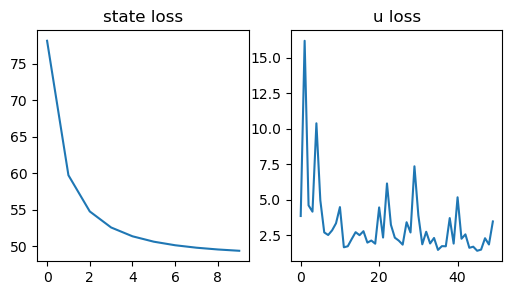

In [173]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(loss_list)
ax[0].set_title('state loss')
ax[1].plot(loss_list_u)
ax[1].set_title('u loss')

In [157]:
print("final loss:", loss_list[-1], loss_list_u[-1])

final loss: 19.706418418884276 0.04725380542874336


Text(0.5, 1.0, 'U Histogram 0.86')

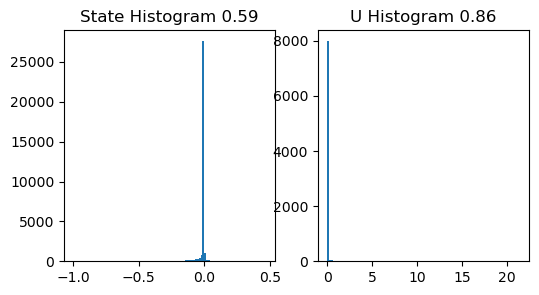

In [166]:
# plot histogram of x_k and u_k
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
_ = plt.hist(x_k.numpy().flatten(), bins=100)
# ratio of zero elements
plt.title(f'State Histogram {float(torch.sum(torch.abs(x_k)<1e-5)/(np.prod(x_k.shape))):.2f}')
plt.subplot(1,2,2)
_ = plt.hist(u_k.numpy().flatten(), bins=100)
plt.title(f'U Histogram {float(torch.sum(torch.abs(u_k)<1e-5)/(np.prod(u_k.shape))):.2f}')

(-0.5, 31.5, 31.5, -0.5)

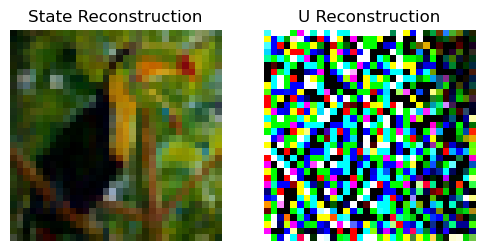

In [167]:
# reconstruction
test_recon = (C_torch @ x_k).view(3,40,40).permute(1,2,0).numpy()
recon = B_torch @ u_k
recon = recon.view(1, out_ch, 24, 24)[:,:,4:-4,4:-4]
recon = unpool(recon, inx)
recon = recon.flatten(1).unsqueeze(-1)
#print(recon.min(), recon.max())
recon = C_torch @ recon
#print(recon.min(), recon.max())
recon = recon.view(3,40,40).permute(1,2,0).numpy()[4:-4,4:-4,:]

# plot both reconstructions
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(test_recon.clip(0,1)[4:-4,4:-4,:])
ax[0].set_title('State Reconstruction')
ax[0].axis('off')
ax[1].imshow(recon.clip(0,1))
ax[1].set_title('U Reconstruction')
ax[1].axis('off')

# Compare with FISTA with the same state $X$

In [96]:
B_fista = nn.ConvTranspose2d(32, 32, kernel_size=9, stride=1, padding=4, bias=False)
B_fista.weight = nn.Parameter(torch.FloatTensor(k_))

In [124]:
xp = x_abs.clone()
xp = xp.view(1, in_ch, 24, 24)[:, :, 9//2:-(9//2), 9//2:-(9//2)]
u = torch.zeros(1, 32, 16, 16, requires_grad=True)
uz = torch.zeros(1, 32, 16, 16, requires_grad=True)

old_u = u.clone().detach()

m4u = 0
lamb = gamma0
protect_u = 0
lossu_fista = []
sparse_u = beta
Lu = torch.ones((1, 1, 1, 1))

tku = 1
tk_1u = 1

B_fista = nn.ConvTranspose2d(32, 32, kernel_size=9, stride=1, padding=4, bias=False)
B_fista.weight = nn.Parameter(torch.FloatTensor(k_))
for u_iter in range(200):
    pred_uz = (1+torch.exp(-B_fista(uz)))*lamb - lamb
    const = (pred_uz * torch.abs(xp)).sum((-1,-2,-3))# + (td_alpha*(self.uz - td)**2).sum((-1,-2,-3))
    const.sum().backward()
    const = const.data.clone().detach()
    grad_zk = (uz.grad.data.clone().detach())
    stop_linesearch = torch.zeros((1, 1))
    zero_tensor = torch.zeros(uz.shape)
    keep_going = 1
    while keep_going and protect_u<20000:#torch.sum(stop_linesearch) != batch_size:# search step size using lipschitz condition
        gk = uz - grad_zk/Lu
        u.data = (torch.sign(gk)*(torch.max((torch.abs(gk)-sparse_u/Lu),zero_tensor))).clone() #soft thresholding
        pred = (1+torch.exp(-B_fista(u)))*lamb - lamb
        temp1 = (pred * torch.abs(xp)).sum((-1,-2,-3))# + (td_alpha*(self.u - td)**2).sum((-1,-2,-3))
        temp2 = const+((u - uz)*grad_zk).sum((-1,-2,-3))+((Lu/2).sum((-1,-2,-3)))*(((u - uz)**2).sum((-1,-2,-3)))
        stop_linesearch[temp1<= temp2] = True
        decay = torch.ones((1, 1))
        decay = (1-stop_linesearch)*2
        decay[decay==0] = 1
        Lu = Lu*decay.unsqueeze(-1).unsqueeze(-1)
        protect_u+=1 
        
        if (temp1.sum())<= (temp2.sum()):
            keep_going = 0
        
    sparse_u = np.maximum(0.985*sparse_u,1e-3)#0.975-100
    tk_1u = 1+((((m4u+1))**8-1)/2) # the major contribution: Faster Fista step
    uz.data = (u.clone().detach() + (tku - 1)/(tk_1u)*(u.clone().detach() - old_u)).clone()
    old_u = u.clone().detach()
    tku = tk_1u
    
    
    lossu_fista.append(temp1.cpu().detach().numpy())#+sparse_u*torch.norm(u,1).cpu().detach().numpy())
    
    uz.grad.zero_()
    m4u += 1

In [89]:
u.max()

tensor(3.3339, grad_fn=<MaxBackward1>)

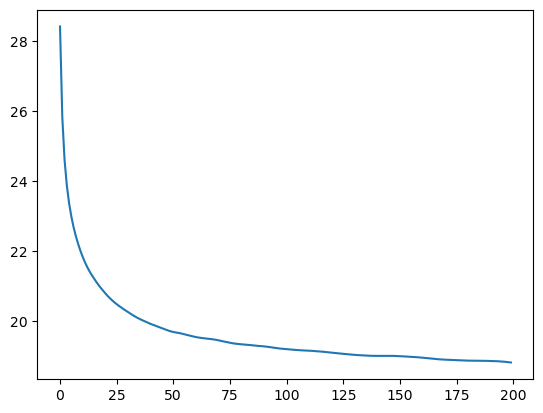

In [125]:
plt.plot(lossu_fista)

In [126]:
lossu_fista[-1].item()

18.80279541015625

Text(0.5, 1.0, 'U Histogram 0.86')

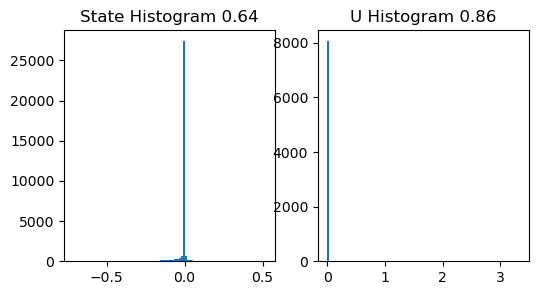

In [127]:
# plot histogram of x_k and u_k
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
_ = plt.hist(x_k.numpy().flatten(), bins=100)
# ratio of zero elements
plt.title(f'State Histogram {float(torch.sum(torch.abs(x_k)<1e-5)/(np.prod(x_k.shape))):.2f}')
plt.subplot(1,2,2)
_ = plt.hist(u.detach().cpu().numpy().flatten(), bins=100)
plt.title(f'U Histogram {float(torch.sum(torch.abs(u_k)<1e-5)/(np.prod(u_k.shape))):.2f}')

torch.Size([1, 32, 16, 16])


(-0.5, 31.5, 31.5, -0.5)

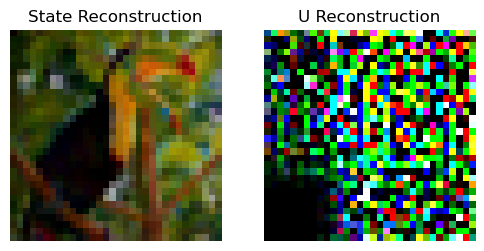

In [128]:
# reconstruction
test_recon = (C_torch @ x_k).view(3,40,40).permute(1,2,0).numpy()
recon = B_fista(u)
print(recon.shape)
recon = recon.view(1, out_ch, 16, 16)
recon = unpool(recon, inx)
recon = recon.flatten(1).unsqueeze(-1)
#print(recon.min(), recon.max())
recon = C_torch @ recon
#print(recon.min(), recon.max())
recon = recon.view(3,40,40).permute(1,2,0).detach().numpy()[4:-4,4:-4,:]

# plot both reconstructions
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(test_recon.clip(0,1)[4:-4,4:-4,:])
ax[0].set_title('State Reconstruction')
ax[0].axis('off')
ax[1].imshow(recon.clip(0,1))
ax[1].set_title('U Reconstruction')
ax[1].axis('off')

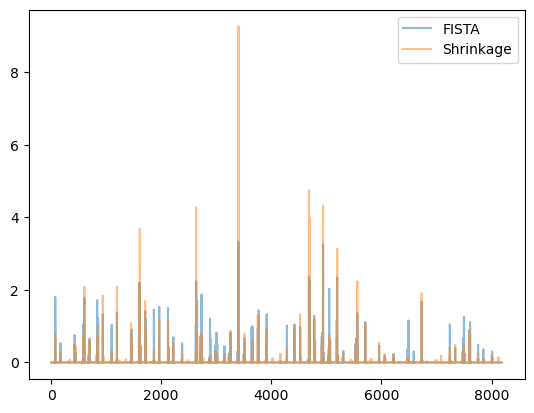

In [129]:
plt.plot(u.flatten().detach().numpy(), alpha=0.5)
plt.plot(u_k.flatten().detach().numpy(), alpha=0.5)
plt.legend(['FISTA','Shrinkage'])

In [123]:
print("sparsity of FISTA: ", torch.sum(u == 0).item()/torch.prod(torch.tensor(u.size())))
print("sparsity of Shrinkage: ", torch.sum(torch.abs(u_k) < 1e-5).item()/u_k.size(1))
print(torch.sum(torch.square(u_k - u.flatten().unsqueeze(-1))).item())

sparsity of FISTA:  tensor(0.6895)
sparsity of Shrinkage:  0.8592529296875
451.3198547363281


torch.Size([1, 32, 16, 16])